In [ ]:

# Nueva base de datos Excel
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

df_nuevo = pd.read_excel("C:\\Users\\Lenovo\\OneDrive\\TESIS\\codigo\\ToxicityModel\\NanoTox _unidas.xlsx")
df_nuevo.head()

,NPs,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class
0,Al2O3,267.0,36.3,64.7,-1.51,24,0.001,1.61,3,0
1,Al2O3,267.0,36.3,64.7,-1.51,24,0.010,1.61,3,0
2,Al2O3,267.0,36.3,64.7,-1.51,24,0.100,1.61,3,0
3,Al2O3,267.0,36.3,64.7,-1.51,24,1.000,1.61,3,0
4,Al2O3,267.0,36.3,64.7,-1.51,24,5.000,1.61,3,0


In [ ]:
# Exploración de columnas relevantes: tipo de estudio y % de viabilidad
print('Columnas disponibles en el dataset:')
print(df_nuevo.columns)

# Mostrar los primeros registros para identificar los valores
print('\nPrimeras filas del dataset:')
print(df_nuevo.head())

# Si existen columnas relacionadas, mostrar ejemplos
for col in ['Assay', 'Tipo', 'Estudio', 'LDH', 'MTT', 'TYB', 'Viabilidad', '%Viabilidad', 'Viability']:
    if col in df_nuevo.columns:
        print(f'Valores únicos en la columna "{col}":')
        print(df_nuevo[col].unique())

In [3]:
# Normalización de datos
def normalise(df):
    df = df.copy()
    if 'hydrosize' in df.columns: df['hydrosize'] = np.log(df['hydrosize'])
    if 'surfarea' in df.columns: df['surfarea'] = np.log(df['surfarea'])
    if 'surfcharge' in df.columns: df['surfcharge'] = StandardScaler().fit_transform(df[['surfcharge']])
    if 'Ec' in df.columns: df['Ec'] = np.log(6.17 + df['Ec'])
    if 'dosage' in df.columns: df['dosage'] = np.log10(df['dosage'])
    if 'Expotime' in df.columns: df['Expotime'] = np.log(df['Expotime'] / 3) / np.log(2)
    if 'e' in df.columns: df['e'] = np.log(df['e'])
    return df

df_nuevo_norm = normalise(df_nuevo)
df_nuevo_norm.head()

,NPs,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class
0,Al2O3,5.587249,1.450015,4.169761,1.539015,3.0,-3.00000,0.476234,3,0
1,Al2O3,5.587249,1.450015,4.169761,1.539015,3.0,-2.00000,0.476234,3,0
2,Al2O3,5.587249,1.450015,4.169761,1.539015,3.0,-1.00000,0.476234,3,0
3,Al2O3,5.587249,1.450015,4.169761,1.539015,3.0,0.00000,0.476234,3,0
4,Al2O3,5.587249,1.450015,4.169761,1.539015,3.0,0.69897,0.476234,3,0


In [4]:
# Selección de variables para el modelado
features = ['hydrosize','surfcharge','surfarea','Ec','Expotime','dosage','e','NOxygen']
features = [f for f in features if f in df_nuevo_norm.columns] # Solo las que existan

In [5]:
# Balanceo de clases y preparación de datos
if 'class' in df_nuevo_norm.columns:
    # Usar directamente la columna 'class' como variable binaria (0=noToxic, 1=Toxic)
    X = df_nuevo_norm[features]
    y = df_nuevo_norm['class']
    smote = SMOTE(random_state=42)
    X_bal, y_bal = smote.fit_resample(X, y)
    print('Balance de clases:', pd.Series(y_bal).value_counts())
else:
    print('No se encontró la columna "class" en la nueva base de datos.')


Balance de clases: class
0    809
1    809
Name: count, dtype: int64


In [6]:
# Entrenamiento de modelos
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

In [7]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [8]:
# SVM (kernel lineal)
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Red Neuronal (MLP, 1 capa oculta)
mlp = MLPClassifier(hidden_layer_sizes=(16,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

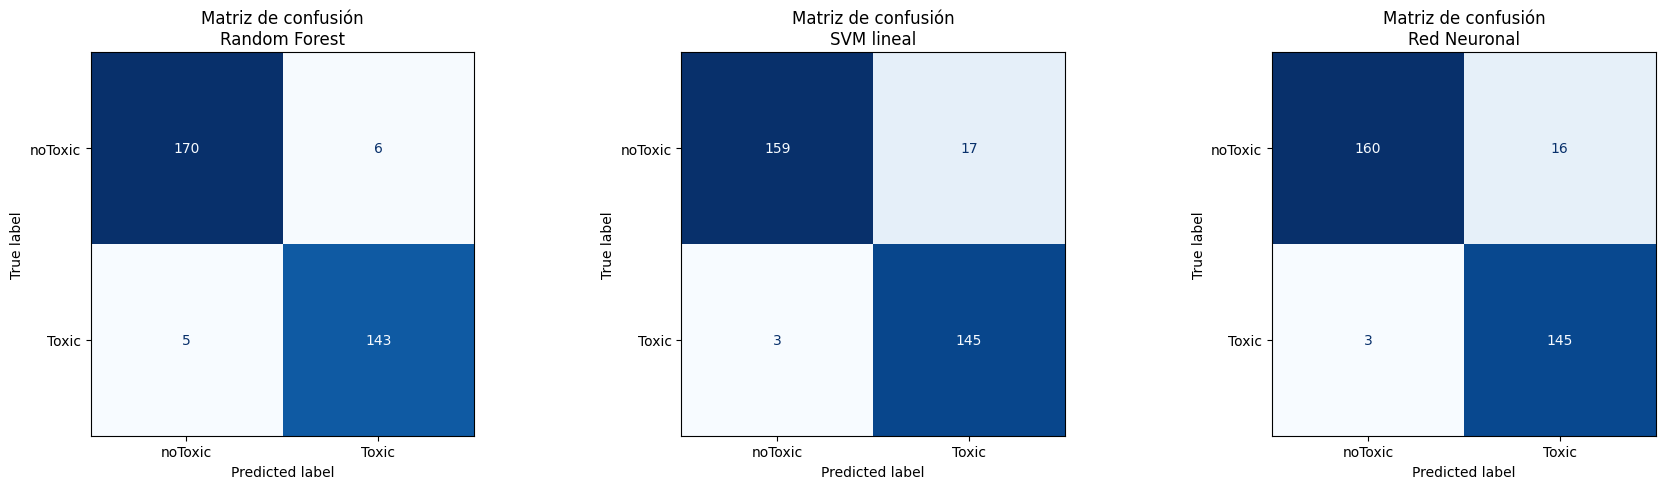

In [ ]:
# Visualización de métricas y matrices de confusión
model_names = ['Random Forest', 'SVM lineal', 'Red Neuronal']
y_preds = [y_pred_rf, y_pred_svm, y_pred_mlp]

fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, (name, y_pred) in enumerate(zip(model_names, y_preds)):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['noToxic', 'Toxic'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Matriz de confusión\n{name}')
plt.tight_layout()
plt.show()

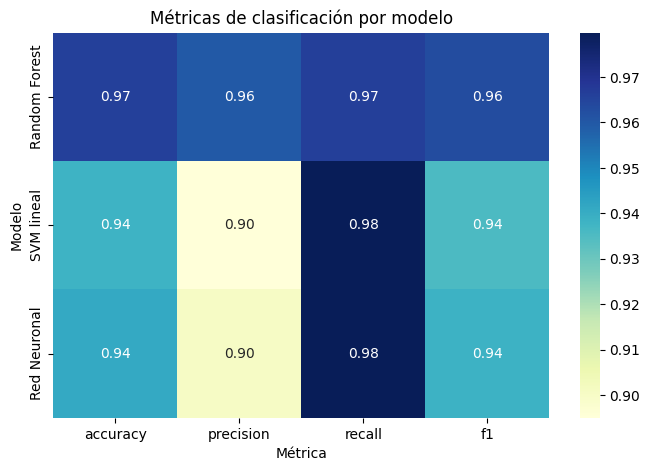

In [10]:
# Visualización de métricas de clasificación
metrics = ['accuracy', 'precision', 'recall', 'f1']
scores = []
for y_pred in y_preds:
    scores.append([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0)
    ])
scores_df = pd.DataFrame(scores, columns=metrics, index=model_names)

plt.figure(figsize=(8,5))
sns.heatmap(scores_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Métricas de clasificación por modelo')
plt.ylabel('Modelo')
plt.xlabel('Métrica')
plt.show()

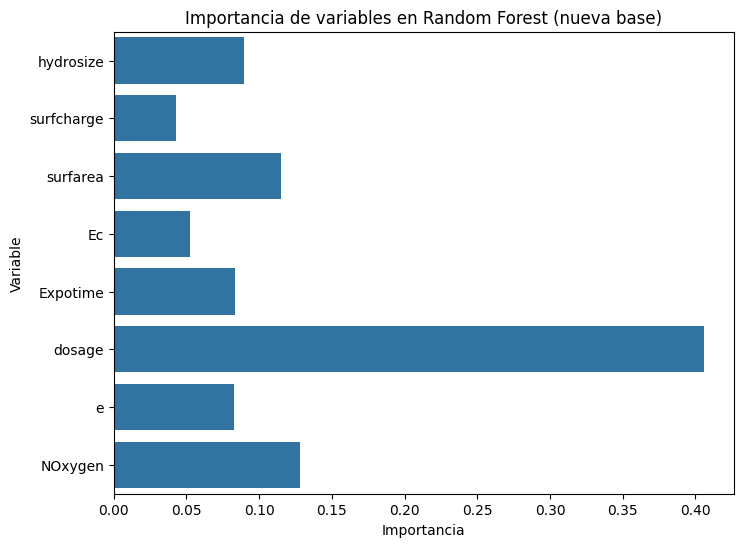

Las variables con mayor importancia contribuyen más a la predicción de toxicidad según el modelo Random Forest.


In [11]:
# Interpretación de resultados y visualización de importancia de variables
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names)
plt.title('Importancia de variables en Random Forest (nueva base)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()
print('Las variables con mayor importancia contribuyen más a la predicción de toxicidad según el modelo Random Forest.')